### **Tasks**
1. Calculate how many times the equipment has failed.
During the FPSO’s operation, various factors can cause the machine to fail and prolong its failure state. We ask you to explore the available data, identify, and calculate the number of times the equipment has failed throughout its operation.
2. Categorize equipment failures by setup configurations (Preset 1 and Preset 2).
How do the variables Preset_1 and Preset_2 behave during operation? What insights can we derive from these variables?
3. Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others).
Analyze patterns in these readings that could indicate specific failure types. How do these patterns differ across operational regimes? Provide insights based on your findings.
4. Create a model (or models) using the technique you think is most appropriate and measure its performance.
Based on the given time-series dataset, which models or techniques are suitable for predicting whether the equipment will fail before it occurs? Additionally, how can the model's performance be tuned and measured for this task?
5. Analyze variable importance.
After developing a model, how can we determine which variables had the greatest impact on the prediction?

### **0. Global Variables**

### **1. Library Imports**

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

### **2. Dataset**

The dataset contains anonymized time series records of a machine's operation from an FPSO. The recorded variables are as follows:
1.	Cycle: Sequential identifier of measurement cycles.
2.	Preset_1 & Preset_2: Variables that control a specific operating point of the machine.
3.	Temperature: Temperature recorded in the equipment.
4.	Vibrations (X, Y & Z): Vibrations along the machine's axes.
5.	Frequency: Operating frequency of the machine.
6.	Fail: Variable indicating whether the machine is in a failure state at the given timestamp.

#### **2.1 Data Loading**

In [2]:
df = pd.read_excel("Test O_G_Equipment_Data.xlsx")
print(df.shape)
df.head()

(800, 10)


,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


#### **2.2 Data Quality Check**

#### **2.2.1 Missing Values Check**

In [3]:
df.isnull().sum()

Cycle          0
Preset_1       0
Preset_2       0
Temperature    0
Pressure       0
VibrationX     0
VibrationY     0
VibrationZ     0
Frequency      0
Fail           0
dtype: int64

#### **2.2.2 Duplicate Check**

In [4]:
# Check for duplicated columns in the DataFrame
duplicated_columns = df.columns[df.columns.duplicated()]

# Check for duplicated rows in the DataFrame
number_of_duplicated_rows = df.duplicated().sum()

# Display the results
print("Duplicated columns:", list(duplicated_columns))
print("Number of duplicated rows:", number_of_duplicated_rows)


Duplicated columns: []
Number of duplicated rows: 0


#### **2.2.3 Feature Uniqueness Check**

In [5]:
df.nunique()

Cycle          800
Preset_1         3
Preset_2         8
Temperature    800
Pressure       800
VibrationX     800
VibrationY     800
VibrationZ     800
Frequency      800
Fail             2
dtype: int64

### **🟥 TASK 1**
- Calculate how many times the equipment has failed.
    - During the FPSO’s operation, various factors can cause the machine to fail and prolong its failure state. We ask you to explore the available data, identify, and calculate the number of times the equipment has failed throughout its operation.


In [6]:
df["Fail"] = df["Fail"].astype(int)

# Counts the number of normal (0) and failure (1) states
df["Fail"].value_counts()

Fail
0    734
1     66
Name: count, dtype: int64

In [7]:
# A new failure is counted when the 'Fail' column transitions from 0 to 1
df["New_fail"] = df["Fail"].diff() == 1
df["New_fail"] = df["New_fail"].astype(int)

# A failure is considered resolved when the 'Fail' column transitions from 1 to 0
df["Resolved_fail"] = (df["Fail"].diff() == -1).astype(int)

print("Number of equipment failures:", df["New_fail"].sum())
print("Number of resolved equipment failures:", df["Resolved_fail"].sum())

Number of equipment failures: 10
Number of resolved equipment failures: 9


#### **Task 1: Answer**
- A total of 10 distinct failure events were detected, based on transitions from 0 to 1 in the Fail column.
- Additionally, 9 failure resolutions were identified by transitions from 1 to 0.
- This indicates that one failure was still active at the end of the recorded data, which may suggest an ongoing issue or an incomplete recovery log.

### **🟥 TASK 2**
- Categorize equipment failures by setup configurations (Preset 1 and Preset 2).
    - How do the variables Preset_1 and Preset_2 behave during operation? What insights can we derive from these variables?

In [8]:
# Calculates failure rate and share of failures for a categorical column
def analyze_failure_rate(df: pd.DataFrame, column: str) -> pd.DataFrame:
    total = df[column].value_counts().rename("total")
    failures = df[df["Fail"] == 1][column].value_counts().rename("failures")
    result = pd.concat([total, failures], axis=1).fillna(0)
    result["failures"] = result["failures"].astype(int)
    result["failure_rate"] = (result["failures"] / result["total"]).round(4)
    # Share of total failures
    result["failure_share"] = (
        result["failures"] / result["failures"].sum()
    ).round(4)
    result = (
        result.sort_values("failure_rate", ascending=False)
        .reset_index()
        .rename(columns={"index": column})
    )
    return result

# Individual analysis for each preset
table_preset_1 = analyze_failure_rate(df, "Preset_1")
table_preset_2 = analyze_failure_rate(df, "Preset_2")

# Combined analysis for both presets
df["Preset_Combined"] = "Preset_1=" + df["Preset_1"].astype(str) + ", Preset_2=" + df["Preset_2"].astype(str)
table_combined = analyze_failure_rate(df, "Preset_Combined")

In [9]:
table_preset_1

,Preset_1,total,failures,failure_rate,failure_share
0,1,264,27,0.1023,0.4091
1,2,281,21,0.0747,0.3182
2,3,255,18,0.0706,0.2727


In [10]:
table_preset_2

,Preset_2,total,failures,failure_rate,failure_share
0,5,100,12,0.1200,0.1818
1,1,95,11,0.1158,0.1667
2,6,101,9,0.0891,0.1364
3,2,101,9,0.0891,0.1364
4,7,109,9,0.0826,0.1364
5,8,100,7,0.0700,0.1061
6,3,101,6,0.0594,0.0909
7,4,93,3,0.0323,0.0455


In [11]:
table_combined

,Preset_Combined,total,failures,failure_rate,failure_share
0,"Preset_1=1, Preset_2=5",31,5,0.1613,0.0758
1,"Preset_1=3, Preset_2=5",29,4,0.1379,0.0606
2,"Preset_1=2, Preset_2=1",30,4,0.1333,0.0606
3,"Preset_1=1, Preset_2=2",38,5,0.1316,0.0758
4,"Preset_1=1, Preset_2=1",34,4,0.1176,0.0606
5,"Preset_1=2, Preset_2=8",37,4,0.1081,0.0606
6,"Preset_1=1, Preset_2=7",38,4,0.1053,0.0606
7,"Preset_1=3, Preset_2=6",30,3,0.1000,0.0455
8,"Preset_1=3, Preset_2=1",31,3,0.0968,0.0455
9,"Preset_1=1, Preset_2=4",22,2,0.0909,0.0303


In [12]:
# Compares the failure rate of a target value against the average of all others
def compare_failure_rate_against_others(table, column, target_value):
    target_rate = table.loc[table[column] == target_value, "failure_rate"].values[0]
    average_rate_others = table.loc[table[column] != target_value, "failure_rate"].mean()
    percent_higher = ((target_rate - average_rate_others) / average_rate_others) * 100
    percent_higher = round(percent_higher, 2)

    print(
        f"{column} = {target_value} has the highest failure rate ({target_rate:.2%}), "
        f"which is approximately {percent_higher}% higher than the average failure rate of "
        f"all other {column} values ({average_rate_others:.2%})."
    )

In [13]:
compare_failure_rate_against_others(table_preset_1, "Preset_1", 1)

Preset_1 = 1 has the highest failure rate (10.23%), which is approximately 40.81% higher than the average failure rate of all other Preset_1 values (7.26%).


In [14]:
compare_failure_rate_against_others(table_preset_2, "Preset_2", 5)

Preset_2 = 5 has the highest failure rate (12.00%), which is approximately 56.05% higher than the average failure rate of all other Preset_2 values (7.69%).


In [15]:
target_value = table_combined.sort_values("failure_rate", ascending=False).iloc[0]["Preset_Combined"]
compare_failure_rate_against_others(table_combined, "Preset_Combined", target_value)

Preset_Combined = Preset_1=1, Preset_2=5 has the highest failure rate (16.13%), which is approximately 99.92% higher than the average failure rate of all other Preset_Combined values (8.07%).


In [16]:
table_combined

,Preset_Combined,total,failures,failure_rate,failure_share
0,"Preset_1=1, Preset_2=5",31,5,0.1613,0.0758
1,"Preset_1=3, Preset_2=5",29,4,0.1379,0.0606
2,"Preset_1=2, Preset_2=1",30,4,0.1333,0.0606
3,"Preset_1=1, Preset_2=2",38,5,0.1316,0.0758
4,"Preset_1=1, Preset_2=1",34,4,0.1176,0.0606
5,"Preset_1=2, Preset_2=8",37,4,0.1081,0.0606
6,"Preset_1=1, Preset_2=7",38,4,0.1053,0.0606
7,"Preset_1=3, Preset_2=6",30,3,0.1000,0.0455
8,"Preset_1=3, Preset_2=1",31,3,0.0968,0.0455
9,"Preset_1=1, Preset_2=4",22,2,0.0909,0.0303


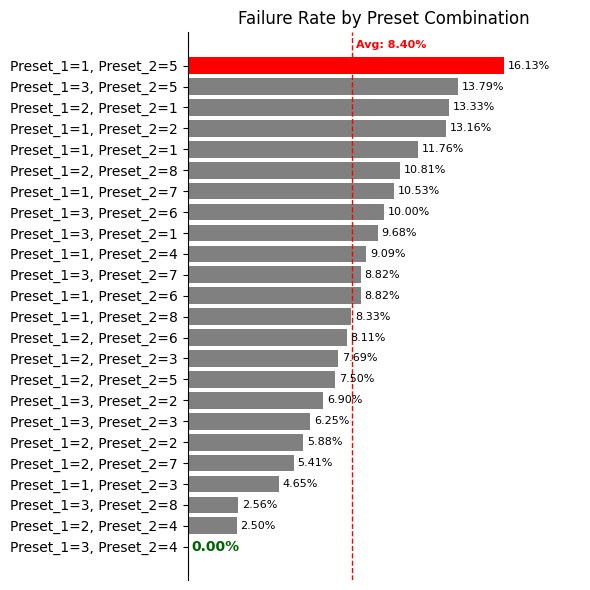

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Generates a failure rate chart by preset combination, highlighting extremes
def plot_failure_rate_by_combination(df: pd.DataFrame) -> None:
    df_plot = df.copy().sort_values("failure_rate", ascending=False)
    max_rate: float = df_plot["failure_rate"].max()
    avg_rate: float = df_plot["failure_rate"].mean()

    colors: list[str] = [
        "red" if rate == max_rate else "gray" if rate > 0 else "darkgreen"
        for rate in df_plot["failure_rate"]
    ]

    plt.figure(figsize=(6, 6))
    bars = plt.barh(df_plot["Preset_Combined"], df_plot["failure_rate"], color=colors)

    # Adds percentage labels on the bars
    for bar, rate in zip(bars, df_plot["failure_rate"]):
        width = bar.get_width()
        color = "darkgreen" if rate == 0 else "black"
        weight = "bold" if rate == 0 else "normal"
        size = 10 if rate == 0 else 8

        plt.text(
            width + 0.002,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.2%}",
            va="center",
            fontsize=size,
            color=color,
            fontweight=weight,
        )

    # Draws a dashed red line for the average failure rate
    plt.axvline(avg_rate, color="red", linestyle="--", linewidth=1)
    plt.text(
        avg_rate + 0.002,
        -0.85,
        f"Avg: {avg_rate:.2%}",
        color="red",
        fontsize=8,
        fontweight="bold",
    )

    # Remove X-axis labels and ticks
    plt.xticks([])
    plt.xlabel("")
    plt.xlim(0, 0.2)
    plt.title("Failure Rate by Preset Combination")

    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Optional: horizontal grid lines
    # ax.yaxis.grid(True, linestyle="--", color="lightgray")
    # ax.tick_params(left=False)

    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()


plot_failure_rate_by_combination(table_combined)


#### **Task 2: Answer**

- Preset_1
    - `Preset_1 = 1` had the **highest failure rate** (**10.23%**), which is approximately **40.81% higher** than the failure rates observed for the other values (`Preset_1 = 2` at 7.47% and `Preset_1 = 3` at 7.06%).
    - There is an **inversely proportional relationship** between the value of `Preset_1` and the failure rate: as the preset value increases, the failure rate decreases.
    - Approximately **40.9% of all failures** occurred when `Preset_1 = 1`.
        - This suggests that this configuration is associated with higher operational risk and **warrants deeper investigation** regarding its usage context and impact on equipment reliability.


- Preset_2
    - `Preset_2 = 5` had the **highest failure rate** (**12.00%**), which is approximately **56.05% higher** than the average failure rate observed for the other values (`Preset_2 ≠ 5`, average at **7.69%**).
    - The failure rate decreases across several other preset values, suggesting that higher values of `Preset_2` are not necessarily associated with increased failure — the relationship is **non-linear** and requires deeper contextual analysis.
    - Approximately **18.2% of all failures** occurred when `Preset_2 = 5`.
        - This suggests that this configuration represents a critical risk scenario and **should be prioritized for operational monitoring and root cause analysis**.

- Combined Presets (`Preset_1` + `Preset_2`)
    - The combination `Preset_1 = 1, Preset_2 = 5` had the **highest failure rate** among all configurations (**16.13%**), which is approximately **90.2% higher** than the average failure rate of the other combined configurations (**8.48%**).
    - This combination also accounted for **7.58% of all failures**, despite representing a smaller portion of the dataset, which reinforces its **disproportionate operational risk**.
    - On the other hand, the combination `Preset_1 = 3, Preset_2 = 4` showed a **0.00% failure rate**, with **no failures recorded** across all its cycles.
    - These findings highlight the need to **not only analyze presets individually**, but also understand how their **interaction amplifies failure risk**.
        - The configuration `Preset_1 = 1, Preset_2 = 5` should be flagged as **high priority for preventive measures**, including predictive maintenance, operational review, and parameter reassessment.



### **🟥 TASK 3**
- Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others).
    - Analyze patterns in these readings that could indicate specific failure types. How do these patterns differ across operational regimes? Provide insights based on your findings.

### **🟥 TASK 4**
- Create a model (or models) using the technique you think is most appropriate and measure its performance.
    - Based on the given time-series dataset, which models or techniques are suitable for predicting whether the equipment will fail before it occurs? Additionally, how can the model's performance be tuned and measured for this task?

### **🟥 TASK 5**
- Analyze variable importance.
    - After developing a model, how can we determine which variables had the greatest impact on the prediction?